<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

# 固定的資料前處理 (收合)

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/*/*/*.png')
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])
print(file_paths)


['/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/000.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/001.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/002.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/003.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/004.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/005.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/006.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/007.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/008.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/bent_lead/009.png', '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor/test/cut_lead/000.png', '/content/drive/MyDrive/Colab No

In [ ]:
all_data = [] #初始化一個空的 list，準備儲存所有讀進來的圖片

for img in tqdm(file_paths):
    img = cv2.imread(img) #用 OpenCV (cv2) 讀取圖片
    img = img[..., ::-1] #把圖片從 BGR 格式轉成 RGB 格式
    all_data.append(img)

all_data = np.stack(all_data) #把 list 裡的所有圖片轉成一個 NumPy 陣列（維度會變成 [num_images, height, width, 3]）
print(all_data.shape) # 10 張圖片，每張大小為 1024x1024、3 個 channel（RGB）

  0%|          | 0/60 [00:00<?, ?it/s]

(60, 1024, 1024, 3)


Classes: ['bent_lead', 'cut_lead', 'damaged_case', 'good', 'misplaced']


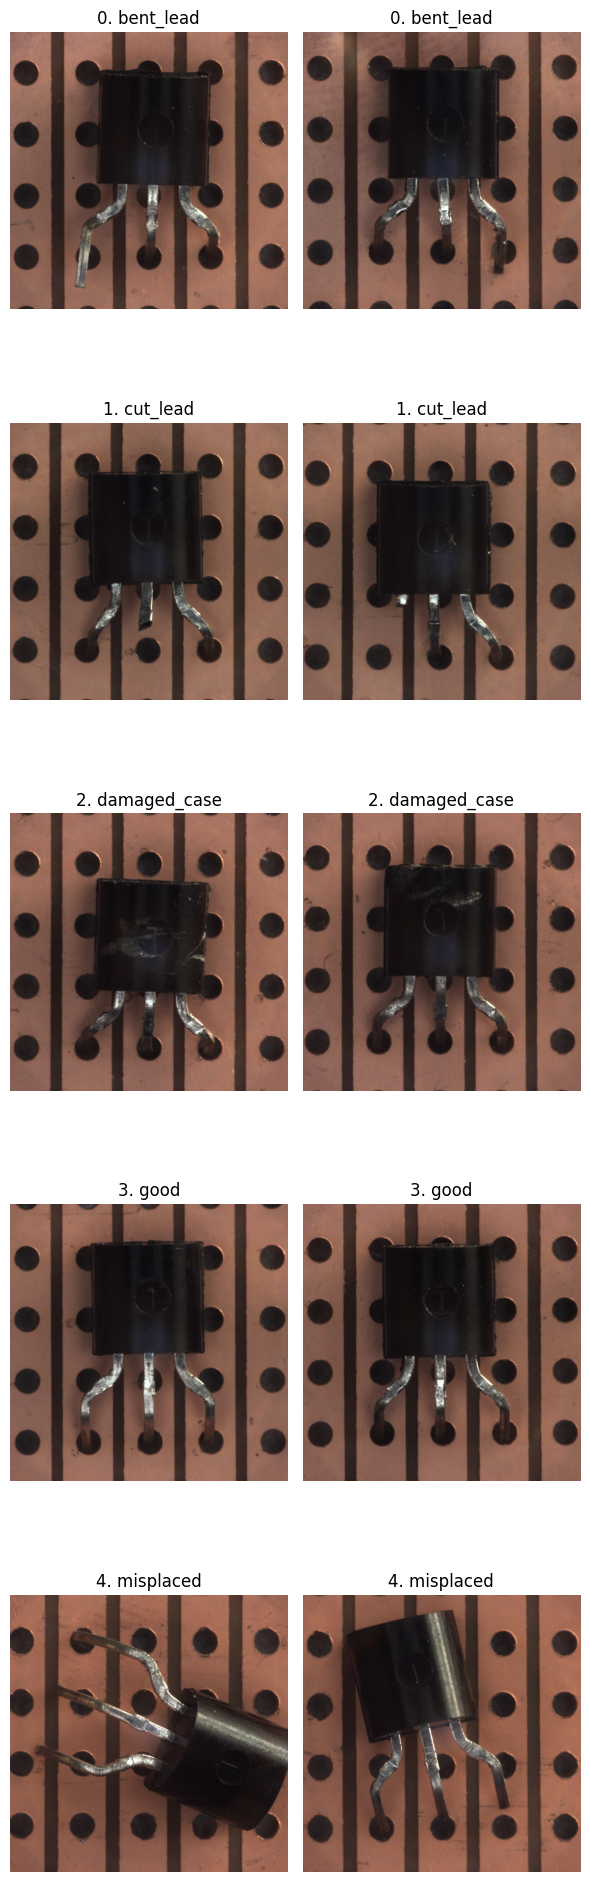

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#解析每張圖片的類別名稱，並整理出不重複的類別清單 classes，再進行排序
classes = sorted(set([path.split('/')[9] for path in file_paths])) #將檔案路徑以 / 拆開成多個字串
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes): # 針對每個類別進行迴圈
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## Data Loading and Preprocessing

切分為訓練集和驗證集，並製作對應的 label（標籤），同時把資料格式轉成 PyTorch 模型訓練需要的形式。

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 5
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

# 對每個類別做切分，分成訓練/驗證資料 (假設圖片按類別順序排列)
for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class]) #把多張圖片（list）加入清單中

# 將影像轉換成 PyTorch 要求的格式，從[batch, height, width, channel] 到 [batch, channel, height, width]
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

# 對 y 製作標籤（labels）
y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')


Shape of x_train: (40, 3, 1024, 1024)
Shape of x_val: (10, 3, 1024, 1024)
Shape of y_train: (40,)
Shape of y_val: (10,)


# 主程式碼

## Baseline Model : epoch=50、batch_size=32

test_acc=0.4

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1.8625, Train acc: 15.0000%, Val loss: 1.6764, Val acc: 20.0000%, Best Val loss: 1.6764 Best Val acc: 20.00%
Epoch 2/50, Train loss: 1.8117, Train acc: 20.0000%, Val loss: 1.6692, Val acc: 20.0000%, Best Val loss: 1.6692 Best Val acc: 20.00%
Epoch 3/50, Train loss: 1.8871, Train acc: 12.5000%, Val loss: 1.6694, Val acc: 20.0000%, Best Val loss: 1.6692 Best Val acc: 20.00%
Epoch 4/50, Train loss: 2.0925, Train acc: 15.0000%, Val loss: 1.7022, Val acc: 20.0000%, Best Val loss: 1.6692 Best Val acc: 20.00%
Epoch 5/50, Train loss: 1.6507, Train acc: 25.0000%, Val loss: 1.7622, Val acc: 20.0000%, Best Val loss: 1.6692 Best Val acc: 20.00%
Epoch 6/50, Train loss: 1.7557, Train acc: 32.5000%, Val loss: 1.8443, Val acc: 20.0000%, Best Val loss: 1.6692 Best Val acc: 20.00%
Epoch 7/50, Train loss: 1.7216, Train acc: 30.0000%, Val loss: 1.9543, Val acc: 20.0000%, Best Val loss: 1.6692 Best Val acc: 20.00%
Epoch 8/50, Train loss: 1.6232, Train acc: 17.5000%, Val loss: 2.0043

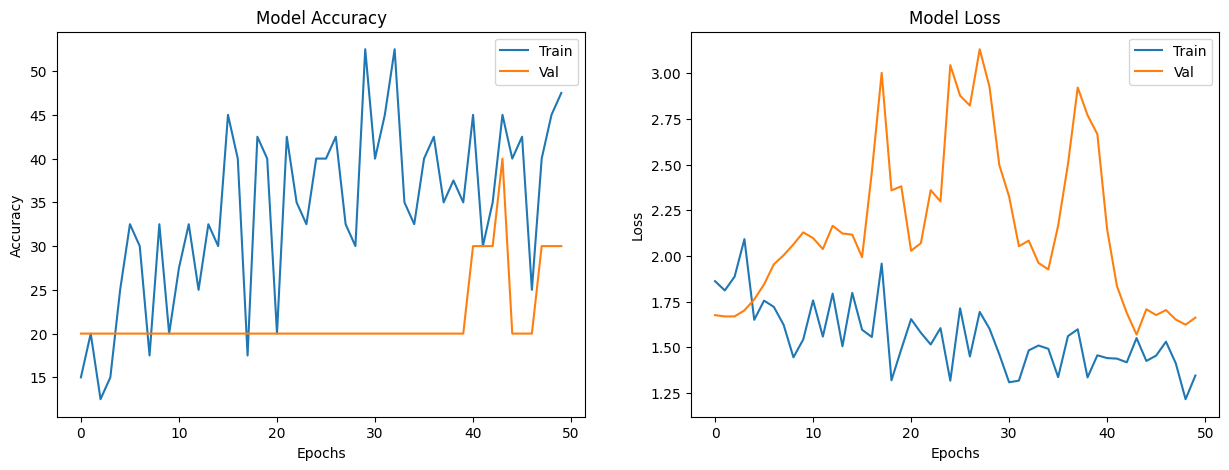

tensor([0, 3, 3, 3, 0, 3, 3, 3, 0, 4], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 40.0%


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

##################################    建立自訂的 PyTorch Dataset 類別，並使用 torchvision 的資料增強（transform）進行訓練與驗證資料的處理。   #################################################
# 定義訓練資料與驗證資料的 transforms（轉換/增強操作）
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),         # 將影像縮放至 32x32（統一尺寸）
        transforms.AutoAugment(),            # 自動資料增強策略（隨機旋轉、對比、裁切等）
        transforms.RandomHorizontalFlip(),   # 隨機水平翻轉
        transforms.ToTensor(),               # 轉換為 PyTorch tensor 並正規化至 [0, 1]
    ]
)

# 驗證集：只需縮放與轉成 tensor，不需做增強，以確保評估穩定。
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 繼承 torch.utils.data.Dataset，自訂如何讀資料、讀幾筆、做 transform
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x                   # 影像資料（形狀為 [N, C, H, W]）
        self.y = torch.from_numpy(y).long()       # 標籤轉成 PyTorch tensor（長整數型）
        self.transform = transform            # 要套用的 transform（可為 train 或 val）

    def __len__(self):
        return len(self.x) # 告訴 PyTorch 這個資料集中有多少筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 從 [C, H, W] 轉回 [H, W, C]（給PIL用），PIL.Image.fromarray() 要吃 [H, W, C] 格式，所以要 transpose
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 定義 batch_size
batch_size = 32

#使用自訂的 MyDataset 類別，將資料與對應的 transform 傳進去
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

#建立 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

##########################################  Defining Neural Networks   #################################################
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# 載入 ResNet-18 預訓練模型，可以用這個模型進行「特徵提取」或「微調」
# 這個模型是在 ImageNet（1000 類）上訓練的
model = models.resnet18(weights='IMAGENET1K_V1') #weights='IMAGENET1K_V1' 表示載入官方預訓練權重

# 凍結整個 ResNet-18 的特徵提取部分，表示訓練時這些權重不會被更新，只會訓練「最後那層分類器」，不會動到前面學到的特徵
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 5 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
#print(model)

###########################################   Training the Neural Network   #################################################
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
model = model.cuda()

#初始化最佳驗證 loss 與 acc，用來儲存表現最好的模型
best_val_loss = float('inf')
best_val_acc = -1

#損失函數與優化器設定
criterion = nn.CrossEntropyLoss() #交叉熵損失函數
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#使用餘弦退火學習率（Cosine Annealing），讓學習率在訓練過程中慢慢下降至 eta_min=0
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

#Epoch 訓練與驗證主迴圈
for epoch in tqdm(range(epochs)):
    # Training
    model.train() #模型設為訓練模式（啟用 dropout、BN）
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda() #把資料與標籤送進 GPU
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad() #執行 forward pass
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels) #計算損失
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update，根據餘弦退火策略調整學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

##########################################   Visualizing model performance   ##########################################
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#########################   Load Trained Model and Evaluate   ############################

# 載入已儲存的最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad(): # 告訴 PyTorch：「以下程式碼不需要計算梯度」，這樣可以節省記憶體與加速推論（inference）。

    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

## 第一題

In [ ]:
import os
from PIL import Image
from collections import defaultdict

dataset_path = '/content/drive/MyDrive/Colab Notebooks/DL_1132/HW3/transistor'  # ← 這裡請換成你實際解壓路徑

# 計算資料夾內的圖像分布
def count_images(path):
    image_count = 0
    image_sizes = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.png'):
                image_count += 1
                if len(image_sizes) < 10:  # 只記前10張的尺寸作為代表
                    img = Image.open(os.path.join(root, file))
                    image_sizes.append(img.size)  # (width, height)
    return image_count, image_sizes

# 1. 缺陷類別與類型名稱（只看 test 子資料夾）
test_dir = os.path.join(dataset_path, 'test')
defect_classes = sorted(os.listdir(test_dir))
num_defect_classes = len(defect_classes)

# 2. 計算訓練與測試圖片數
train_dir = os.path.join(dataset_path, 'train')
train_dist = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
test_dist = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)}

# 3. 計算總圖片數
total_train_images, _ = count_images(train_dir)
total_test_images, test_image_sizes = count_images(test_dir)
total_images = total_train_images + total_test_images

# 4. 整理結果輸出
print(f'📌 Number of defect classes: {num_defect_classes}')
print(f'📌 Types of defect classes: {defect_classes}')
print(f'📌 Total images used: {total_images}')
print(f'📌 Train distribution: {train_dist}')
print(f'📌 Test distribution: {test_dist}')

# 5. 印出圖像尺寸統計（取 test set 的 10 張為範例）
print(f'📌 Sample image dimensions (from test set):')
for i, size in enumerate(test_image_sizes):
    print(f'   Image {i+1}: {size[0]} x {size[1]}')

📌 Number of defect classes: 5
📌 Types of defect classes: ['bent_lead', 'cut_lead', 'damaged_case', 'good', 'misplaced']
📌 Total images used: 313
📌 Train distribution: {'good': 213}
📌 Test distribution: {'misplaced': 10, 'good': 60, 'damaged_case': 10, 'bent_lead': 10, 'cut_lead': 10}
📌 Sample image dimensions (from test set):
   Image 1: 1024 x 1024
   Image 2: 1024 x 1024
   Image 3: 1024 x 1024
   Image 4: 1024 x 1024
   Image 5: 1024 x 1024
   Image 6: 1024 x 1024
   Image 7: 1024 x 1024
   Image 8: 1024 x 1024
   Image 9: 1024 x 1024
   Image 10: 1024 x 1024


## 第二題

### 方法一 : batch_size=32、epoch=200、restnet18、沒有拿掉/255

test_acc=0.6

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train loss: 1.7113, Train acc: 22.5000%, Val loss: 1.6598, Val acc: 20.0000%, Best Val loss: 1.6598 Best Val acc: 20.00%
Epoch 2/200, Train loss: 1.4946, Train acc: 25.0000%, Val loss: 1.6559, Val acc: 20.0000%, Best Val loss: 1.6559 Best Val acc: 20.00%
Epoch 3/200, Train loss: 1.7062, Train acc: 27.5000%, Val loss: 1.6784, Val acc: 20.0000%, Best Val loss: 1.6559 Best Val acc: 20.00%
Epoch 4/200, Train loss: 1.7589, Train acc: 15.0000%, Val loss: 1.7114, Val acc: 20.0000%, Best Val loss: 1.6559 Best Val acc: 20.00%
Epoch 5/200, Train loss: 1.7147, Train acc: 20.0000%, Val loss: 1.6832, Val acc: 20.0000%, Best Val loss: 1.6559 Best Val acc: 20.00%
Epoch 6/200, Train loss: 1.6609, Train acc: 27.5000%, Val loss: 1.7049, Val acc: 20.0000%, Best Val loss: 1.6559 Best Val acc: 20.00%
Epoch 7/200, Train loss: 1.7542, Train acc: 25.0000%, Val loss: 1.6993, Val acc: 20.0000%, Best Val loss: 1.6559 Best Val acc: 20.00%
Epoch 8/200, Train loss: 1.7206, Train acc: 22.5000%, Val loss

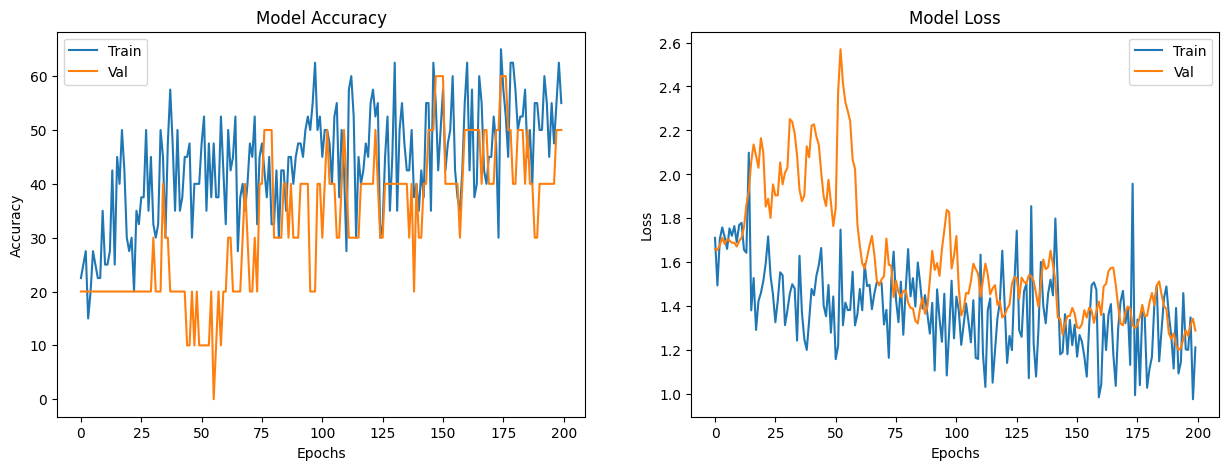

tensor([2, 1, 1, 1, 2, 2, 3, 2, 4, 3], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 60.0%


In [ ]:
##################################    建立自訂的 PyTorch Dataset 類別，並使用 torchvision 的資料增強（transform）進行訓練與驗證資料的處理。   #################################################
# 定義訓練資料與驗證資料的 transforms（轉換/增強操作）
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),         # 將影像縮放至 32x32（統一尺寸）
        transforms.AutoAugment(),            # 自動資料增強策略（隨機旋轉、對比、裁切等）
        transforms.RandomHorizontalFlip(),   # 隨機水平翻轉
        transforms.ToTensor(),               # 轉換為 PyTorch tensor 並正規化至 [0, 1]
    ]
)

# 驗證集：只需縮放與轉成 tensor，不需做增強，以確保評估穩定。
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 繼承 torch.utils.data.Dataset，自訂如何讀資料、讀幾筆、做 transform
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x                   # 影像資料（形狀為 [N, C, H, W]）
        self.y = torch.from_numpy(y).long()       # 標籤轉成 PyTorch tensor（長整數型）
        self.transform = transform            # 要套用的 transform（可為 train 或 val）

    def __len__(self):
        return len(self.x) # 告訴 PyTorch 這個資料集中有多少筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 從 [C, H, W] 轉回 [H, W, C]（給PIL用），PIL.Image.fromarray() 要吃 [H, W, C] 格式，所以要 transpose
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 定義 batch_size
batch_size = 32

#使用自訂的 MyDataset 類別，將資料與對應的 transform 傳進去
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

#建立 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

##########################################  Defining Neural Networks   #################################################

# 載入 ResNet-18 預訓練模型，可以用這個模型進行「特徵提取」或「微調」
# 這個模型是在 ImageNet（1000 類）上訓練的
model = models.resnet18(weights='IMAGENET1K_V1') #weights='IMAGENET1K_V1' 表示載入官方預訓練權重

# 凍結整個 ResNet-18 的特徵提取部分，表示訓練時這些權重不會被更新，只會訓練「最後那層分類器」，不會動到前面學到的特徵
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 5 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
#print(model)

###########################################   Training the Neural Network   #################################################

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 200
model = model.cuda()

#初始化最佳驗證 loss 與 acc，用來儲存表現最好的模型
best_val_loss = float('inf')
best_val_acc = -1

#損失函數與優化器設定
criterion = nn.CrossEntropyLoss() #交叉熵損失函數
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#使用餘弦退火學習率（Cosine Annealing），讓學習率在訓練過程中慢慢下降至 eta_min=0
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

#Epoch 訓練與驗證主迴圈
for epoch in tqdm(range(epochs)):
    # Training
    model.train() #模型設為訓練模式（啟用 dropout、BN）
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda() #把資料與標籤送進 GPU
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad() #執行 forward pass
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels) #計算損失
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update，根據餘弦退火策略調整學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

##########################################   Visualizing model performance   ##########################################

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#########################   Load Trained Model and Evaluate   ############################
# 載入已儲存的最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad(): # 告訴 PyTorch：「以下程式碼不需要計算梯度」，這樣可以節省記憶體與加速推論（inference）。

    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

### 方法二 : batch_size=16、epoch=50、restnet18、沒有拿掉/255

test_acc=0.6

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1.8033, Train acc: 25.0000%, Val loss: 1.6439, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 2/50, Train loss: 1.8009, Train acc: 25.0000%, Val loss: 1.6867, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 3/50, Train loss: 1.7333, Train acc: 15.0000%, Val loss: 1.7030, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 4/50, Train loss: 1.5654, Train acc: 22.5000%, Val loss: 1.6906, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 5/50, Train loss: 1.5192, Train acc: 35.0000%, Val loss: 1.7123, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 6/50, Train loss: 1.7742, Train acc: 20.0000%, Val loss: 1.7853, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 7/50, Train loss: 1.7884, Train acc: 12.5000%, Val loss: 1.9003, Val acc: 20.0000%, Best Val loss: 1.6439 Best Val acc: 20.00%
Epoch 8/50, Train loss: 1.8088, Train acc: 20.0000%, Val loss: 2.2209

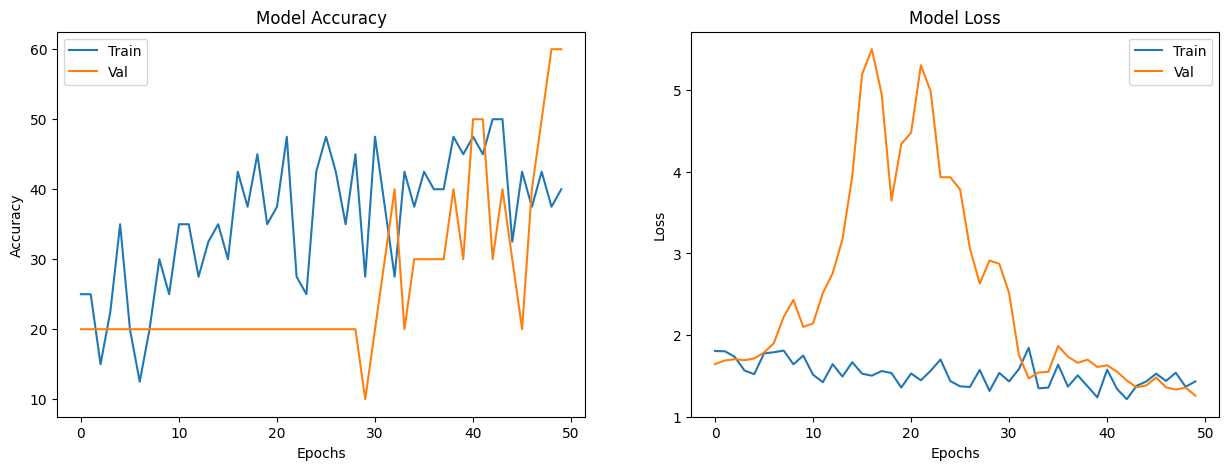

tensor([0, 1, 1, 0, 2, 2, 3, 1, 4, 3], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 60.0%


In [ ]:
##################################    建立自訂的 PyTorch Dataset 類別，並使用 torchvision 的資料增強（transform）進行訓練與驗證資料的處理。   #################################################
# 定義訓練資料與驗證資料的 transforms（轉換/增強操作）
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),         # 將影像縮放至 32x32（統一尺寸）
        transforms.AutoAugment(),            # 自動資料增強策略（隨機旋轉、對比、裁切等）
        transforms.RandomHorizontalFlip(),   # 隨機水平翻轉
        transforms.ToTensor(),               # 轉換為 PyTorch tensor 並正規化至 [0, 1]
    ]
)

# 驗證集：只需縮放與轉成 tensor，不需做增強，以確保評估穩定。
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 繼承 torch.utils.data.Dataset，自訂如何讀資料、讀幾筆、做 transform
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x                   # 影像資料（形狀為 [N, C, H, W]）
        self.y = torch.from_numpy(y).long()       # 標籤轉成 PyTorch tensor（長整數型）
        self.transform = transform            # 要套用的 transform（可為 train 或 val）

    def __len__(self):
        return len(self.x) # 告訴 PyTorch 這個資料集中有多少筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 從 [C, H, W] 轉回 [H, W, C]（給PIL用），PIL.Image.fromarray() 要吃 [H, W, C] 格式，所以要 transpose
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 定義 batch_size
batch_size = 16

#使用自訂的 MyDataset 類別，將資料與對應的 transform 傳進去
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

#建立 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

##########################################  Defining Neural Networks   #################################################

# 載入 ResNet-18 預訓練模型，可以用這個模型進行「特徵提取」或「微調」
# 這個模型是在 ImageNet（1000 類）上訓練的
model = models.resnet18(weights='IMAGENET1K_V1') #weights='IMAGENET1K_V1' 表示載入官方預訓練權重

# 凍結整個 ResNet-18 的特徵提取部分，表示訓練時這些權重不會被更新，只會訓練「最後那層分類器」，不會動到前面學到的特徵
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 5 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
#print(model)

###########################################   Training the Neural Network   #################################################

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
model = model.cuda()

#初始化最佳驗證 loss 與 acc，用來儲存表現最好的模型
best_val_loss = float('inf')
best_val_acc = -1

#損失函數與優化器設定
criterion = nn.CrossEntropyLoss() #交叉熵損失函數
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#使用餘弦退火學習率（Cosine Annealing），讓學習率在訓練過程中慢慢下降至 eta_min=0
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

#Epoch 訓練與驗證主迴圈
for epoch in tqdm(range(epochs)):
    # Training
    model.train() #模型設為訓練模式（啟用 dropout、BN）
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda() #把資料與標籤送進 GPU
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad() #執行 forward pass
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels) #計算損失
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update，根據餘弦退火策略調整學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

##########################################   Visualizing model performance   ##########################################

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#########################   Load Trained Model and Evaluate   ############################
# 載入已儲存的最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad(): # 告訴 PyTorch：「以下程式碼不需要計算梯度」，這樣可以節省記憶體與加速推論（inference）。

    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

###方法三 : batch_size=16、epoch=200、restnet50、沒有拿掉/255

test_acc=0.7

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train loss: 2.2760, Train acc: 17.5000%, Val loss: 3.8918, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 2/200, Train loss: 2.2213, Train acc: 22.5000%, Val loss: 74.2641, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 3/200, Train loss: 2.9849, Train acc: 22.5000%, Val loss: 357.6481, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 4/200, Train loss: 1.9823, Train acc: 42.5000%, Val loss: 212.6005, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 5/200, Train loss: 1.8600, Train acc: 45.0000%, Val loss: 229.5813, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 6/200, Train loss: 1.6989, Train acc: 27.5000%, Val loss: 360.2703, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 7/200, Train loss: 1.6036, Train acc: 42.5000%, Val loss: 225.8360, Val acc: 20.0000%, Best Val loss: 3.8918 Best Val acc: 20.00%
Epoch 8/200, Train loss: 1.5756, Train acc: 37.5000

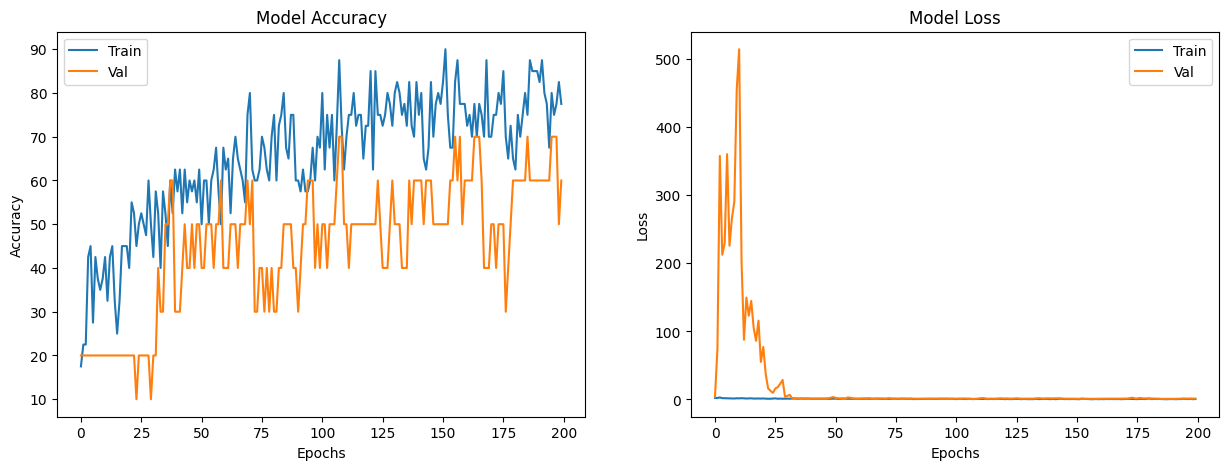

tensor([1, 0, 1, 0, 2, 2, 3, 1, 4, 4], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 70.0%


In [ ]:
##################################    建立自訂的 PyTorch Dataset 類別，並使用 torchvision 的資料增強（transform）進行訓練與驗證資料的處理。   #################################################
# 定義訓練資料與驗證資料的 transforms（轉換/增強操作）
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),         # 將影像縮放至 32x32（統一尺寸）
        transforms.AutoAugment(),            # 自動資料增強策略（隨機旋轉、對比、裁切等）
        transforms.RandomHorizontalFlip(),   # 隨機水平翻轉
        transforms.ToTensor(),               # 轉換為 PyTorch tensor 並正規化至 [0, 1]
    ]
)

# 驗證集：只需縮放與轉成 tensor，不需做增強，以確保評估穩定。
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 繼承 torch.utils.data.Dataset，自訂如何讀資料、讀幾筆、做 transform
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x                   # 影像資料（形狀為 [N, C, H, W]）
        self.y = torch.from_numpy(y).long()       # 標籤轉成 PyTorch tensor（長整數型）
        self.transform = transform            # 要套用的 transform（可為 train 或 val）

    def __len__(self):
        return len(self.x) # 告訴 PyTorch 這個資料集中有多少筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 從 [C, H, W] 轉回 [H, W, C]（給PIL用），PIL.Image.fromarray() 要吃 [H, W, C] 格式，所以要 transpose
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 定義 batch_size
batch_size = 16

#使用自訂的 MyDataset 類別，將資料與對應的 transform 傳進去
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

#建立 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

##########################################  Defining Neural Networks   #################################################

# 載入 ResNet-50 預訓練模型，可以用這個模型進行「特徵提取」或「微調」

from torchvision import models

num_class = 5
model = models.resnet50(weights='IMAGENET1K_V1')

# 可選擇是否凍結部分參數（建議解凍 layer4 以上）
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 修改分類層
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_class)

###########################################   Training the Neural Network   #################################################

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 200
model = model.cuda()

#初始化最佳驗證 loss 與 acc，用來儲存表現最好的模型
best_val_loss = float('inf')
best_val_acc = -1

#損失函數與優化器設定
criterion = nn.CrossEntropyLoss() #交叉熵損失函數
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#使用餘弦退火學習率（Cosine Annealing），讓學習率在訓練過程中慢慢下降至 eta_min=0
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

#Epoch 訓練與驗證主迴圈
for epoch in tqdm(range(epochs)):
    # Training
    model.train() #模型設為訓練模式（啟用 dropout、BN）
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda() #把資料與標籤送進 GPU
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad() #執行 forward pass
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels) #計算損失
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update，根據餘弦退火策略調整學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

##########################################   Visualizing model performance   ##########################################

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#########################   Load Trained Model and Evaluate   ############################
# 載入已儲存的最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad(): # 告訴 PyTorch：「以下程式碼不需要計算梯度」，這樣可以節省記憶體與加速推論（inference）。

    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

### 方法四 : batch_size=16、epoch=200、restnet18、拿掉/255

test_acc=0.8

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train loss: 1.8515, Train acc: 17.5000%, Val loss: 1.5602, Val acc: 30.0000%, Best Val loss: 1.5602 Best Val acc: 30.00%
Epoch 2/200, Train loss: 1.6089, Train acc: 30.0000%, Val loss: 1.5633, Val acc: 30.0000%, Best Val loss: 1.5602 Best Val acc: 30.00%
Epoch 3/200, Train loss: 1.7224, Train acc: 22.5000%, Val loss: 1.5486, Val acc: 30.0000%, Best Val loss: 1.5486 Best Val acc: 30.00%
Epoch 4/200, Train loss: 1.8733, Train acc: 17.5000%, Val loss: 1.5282, Val acc: 40.0000%, Best Val loss: 1.5282 Best Val acc: 40.00%
Epoch 5/200, Train loss: 1.6208, Train acc: 25.0000%, Val loss: 1.4965, Val acc: 70.0000%, Best Val loss: 1.4965 Best Val acc: 70.00%
Epoch 6/200, Train loss: 1.6731, Train acc: 37.5000%, Val loss: 1.4642, Val acc: 60.0000%, Best Val loss: 1.4642 Best Val acc: 70.00%
Epoch 7/200, Train loss: 1.6347, Train acc: 42.5000%, Val loss: 1.4347, Val acc: 60.0000%, Best Val loss: 1.4347 Best Val acc: 70.00%
Epoch 8/200, Train loss: 1.6823, Train acc: 27.5000%, Val loss

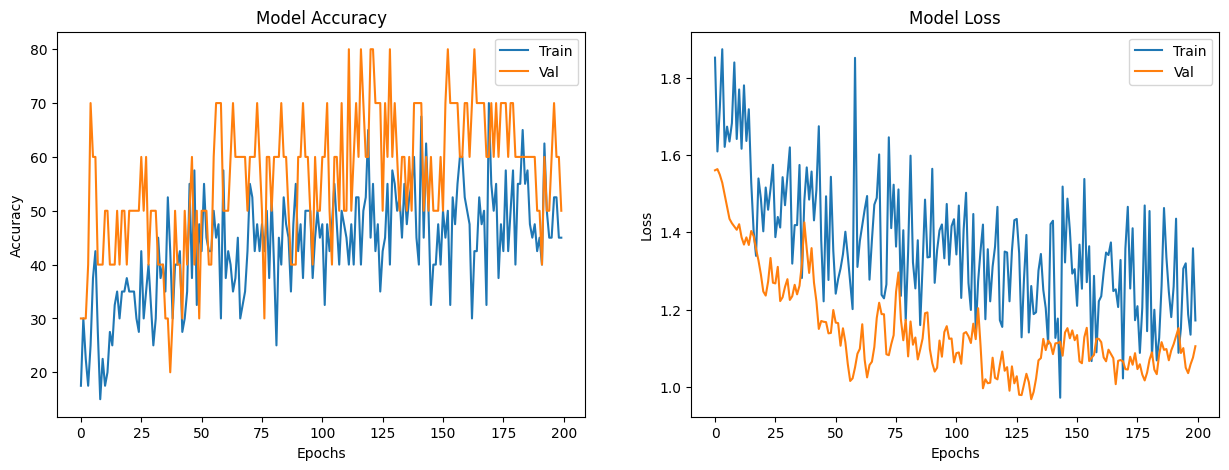

tensor([0, 0, 1, 0, 2, 2, 3, 2, 4, 4], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 80.0%


In [ ]:
##################################    建立自訂的 PyTorch Dataset 類別，並使用 torchvision 的資料增強（transform）進行訓練與驗證資料的處理。   #################################################
# 定義訓練資料與驗證資料的 transforms（轉換/增強操作）
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),         # 將影像縮放至 32x32（統一尺寸）
        transforms.AutoAugment(),            # 自動資料增強策略（隨機旋轉、對比、裁切等）
        transforms.RandomHorizontalFlip(),   # 隨機水平翻轉
        transforms.ToTensor(),               # 轉換為 PyTorch tensor 並正規化至 [0, 1]
    ]
)

# 驗證集：只需縮放與轉成 tensor，不需做增強，以確保評估穩定。
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 繼承 torch.utils.data.Dataset，自訂如何讀資料、讀幾筆、做 transform
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x                   # 影像資料（形狀為 [N, C, H, W]）
        self.y = torch.from_numpy(y).long()       # 標籤轉成 PyTorch tensor（長整數型）
        self.transform = transform            # 要套用的 transform（可為 train 或 val）

    def __len__(self):
        return len(self.x) # 告訴 PyTorch 這個資料集中有多少筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 從 [C, H, W] 轉回 [H, W, C]（給PIL用），PIL.Image.fromarray() 要吃 [H, W, C] 格式，所以要 transpose
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 定義 batch_size
batch_size = 16

#使用自訂的 MyDataset 類別，將資料與對應的 transform 傳進去
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

#建立 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

##########################################  Defining Neural Networks   #################################################

# 載入 ResNet-18 預訓練模型，可以用這個模型進行「特徵提取」或「微調」
# 這個模型是在 ImageNet（1000 類）上訓練的

num_class = 5
model = models.resnet18(weights='IMAGENET1K_V1') #weights='IMAGENET1K_V1' 表示載入官方預訓練權重

# 凍結整個 ResNet-18 的特徵提取部分，表示訓練時這些權重不會被更新，只會訓練「最後那層分類器」，不會動到前面學到的特徵
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 5 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)


###########################################   Training the Neural Network   #################################################

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 200
model = model.cuda()

#初始化最佳驗證 loss 與 acc，用來儲存表現最好的模型
best_val_loss = float('inf')
best_val_acc = -1

#損失函數與優化器設定
criterion = nn.CrossEntropyLoss() #交叉熵損失函數
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#使用餘弦退火學習率（Cosine Annealing），讓學習率在訓練過程中慢慢下降至 eta_min=0
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

#Epoch 訓練與驗證主迴圈
for epoch in tqdm(range(epochs)):
    # Training
    model.train() #模型設為訓練模式（啟用 dropout、BN）
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda() #把資料與標籤送進 GPU
        images = (images)
        labels = labels.cuda()
        optimizer.zero_grad() #執行 forward pass
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels) #計算損失
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images)
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update，根據餘弦退火策略調整學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

##########################################   Visualizing model performance   ##########################################

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#########################   Load Trained Model and Evaluate   ############################
# 載入已儲存的最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad(): # 告訴 PyTorch：「以下程式碼不需要計算梯度」，這樣可以節省記憶體與加速推論（inference）。

    for images, labels in val_loader:

        images = images.cuda()
        images = (images)

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

### 方法五 : batch_size=16、epoch=200、restnet18、拿掉/255、使用 FocalLoss 處理資料不平衡

test_acc=0.8

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train loss: 0.3138, Train acc: 27.5000%, Val loss: 0.2829, Val acc: 20.0000%, Best Val loss: 0.2829 Best Val acc: 20.00%
Epoch 2/200, Train loss: 0.3481, Train acc: 17.5000%, Val loss: 0.2763, Val acc: 10.0000%, Best Val loss: 0.2763 Best Val acc: 20.00%
Epoch 3/200, Train loss: 0.3098, Train acc: 25.0000%, Val loss: 0.2791, Val acc: 10.0000%, Best Val loss: 0.2763 Best Val acc: 20.00%
Epoch 4/200, Train loss: 0.3339, Train acc: 17.5000%, Val loss: 0.2783, Val acc: 0.0000%, Best Val loss: 0.2763 Best Val acc: 20.00%
Epoch 5/200, Train loss: 0.3507, Train acc: 17.5000%, Val loss: 0.2739, Val acc: 20.0000%, Best Val loss: 0.2739 Best Val acc: 20.00%
Epoch 6/200, Train loss: 0.2455, Train acc: 35.0000%, Val loss: 0.2578, Val acc: 30.0000%, Best Val loss: 0.2578 Best Val acc: 30.00%
Epoch 7/200, Train loss: 0.3716, Train acc: 10.0000%, Val loss: 0.2562, Val acc: 10.0000%, Best Val loss: 0.2562 Best Val acc: 30.00%
Epoch 8/200, Train loss: 0.2871, Train acc: 20.0000%, Val loss:

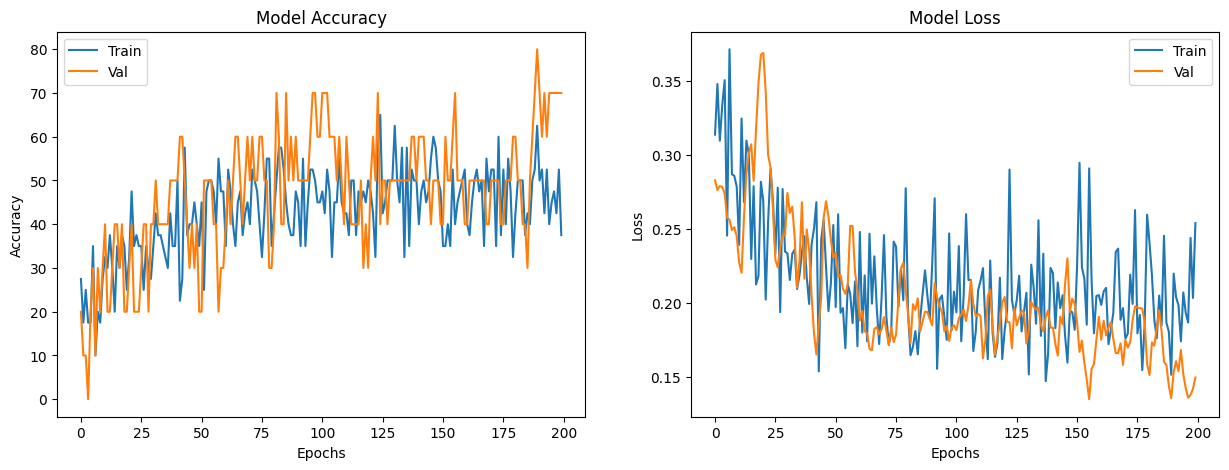

tensor([0, 0, 1, 0, 2, 2, 3, 2, 4, 4], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 80.0%


In [ ]:
##################################    建立自訂的 PyTorch Dataset 類別，並使用 torchvision 的資料增強（transform）進行訓練與驗證資料的處理。   #################################################
# 定義訓練資料與驗證資料的 transforms（轉換/增強操作）
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),         # 將影像縮放至 32x32（統一尺寸）
        transforms.AutoAugment(),            # 自動資料增強策略（隨機旋轉、對比、裁切等）
        transforms.RandomHorizontalFlip(),   # 隨機水平翻轉
        transforms.ToTensor(),               # 轉換為 PyTorch tensor 並正規化至 [0, 1]
    ]
)

# 驗證集：只需縮放與轉成 tensor，不需做增強，以確保評估穩定。
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 繼承 torch.utils.data.Dataset，自訂如何讀資料、讀幾筆、做 transform
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x                   # 影像資料（形狀為 [N, C, H, W]）
        self.y = torch.from_numpy(y).long()       # 標籤轉成 PyTorch tensor（長整數型）
        self.transform = transform            # 要套用的 transform（可為 train 或 val）

    def __len__(self):
        return len(self.x) # 告訴 PyTorch 這個資料集中有多少筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 從 [C, H, W] 轉回 [H, W, C]（給PIL用），PIL.Image.fromarray() 要吃 [H, W, C] 格式，所以要 transpose
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 定義 batch_size
batch_size = 16

#使用自訂的 MyDataset 類別，將資料與對應的 transform 傳進去
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

#建立 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

##########################################  Defining Neural Networks   #################################################

# 載入 ResNet-18 預訓練模型，可以用這個模型進行「特徵提取」或「微調」
# 這個模型是在 ImageNet（1000 類）上訓練的

num_class = 5
model = models.resnet18(weights='IMAGENET1K_V1') #weights='IMAGENET1K_V1' 表示載入官方預訓練權重

# 凍結整個 ResNet-18 的特徵提取部分，表示訓練時這些權重不會被更新，只會訓練「最後那層分類器」，不會動到前面學到的特徵
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 5 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)

# 使用 FocalLoss 處理資料不平衡的問題
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)
        loss = -self.alpha * (1 - pt) ** self.gamma * logpt
        return loss.mean() if self.reduction == 'mean' else loss.sum()


###########################################   Training the Neural Network   #################################################

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 200
model = model.cuda()

#初始化最佳驗證 loss 與 acc，用來儲存表現最好的模型
best_val_loss = float('inf')
best_val_acc = -1

#損失函數與優化器設定
#criterion = nn.CrossEntropyLoss() #交叉熵損失函數
criterion = FocalLoss(gamma=2.0, alpha=0.25)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#使用餘弦退火學習率（Cosine Annealing），讓學習率在訓練過程中慢慢下降至 eta_min=0
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

#Epoch 訓練與驗證主迴圈
for epoch in tqdm(range(epochs)):
    # Training
    model.train() #模型設為訓練模式（啟用 dropout、BN）
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda() #把資料與標籤送進 GPU
        images = (images)
        labels = labels.cuda()
        optimizer.zero_grad() #執行 forward pass
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels) #計算損失
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images)
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update，根據餘弦退火策略調整學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

##########################################   Visualizing model performance   ##########################################

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

#########################   Load Trained Model and Evaluate   ############################
# 載入已儲存的最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad(): # 告訴 PyTorch：「以下程式碼不需要計算梯度」，這樣可以節省記憶體與加速推論（inference）。

    for images, labels in val_loader:

        images = images.cuda()
        images = (images)

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')